Import all necessary modules:

In [2]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt

Function dictionary

In [3]:
# Calculate E(z)
def E(z_i, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    E = np.sqrt(omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l)
    return E;

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

In [4]:
# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, DMDH, omega_m, omega_l):
    # create the output array DMDH
    DMDH = np.copy(z);

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(r"$\Omega_k =$ " + str(omega_k))
    print(r"$\Omega_\Mu =$ " + str(omega_m))
    print(r"$\Omega_\Lambda =$ " + str(omega_l))

    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],omega_m,omega_l) )
    # flat universe
    else:
        DMDH = 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) );

    return DMDH

# proper motion distance for omega_l != 0
def prop_motion(z, DMDH, omega_m, omega_l):
    DMDH = np.copy(z);
    
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(omega_k)
    
    # Calculate D_M/D_H for different universe geometries
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],omega_m,omega_l) )
    # flat universe
    else:
        for i in range(len(z)):
            DMDH[i] = DCDH_int(z[i], omega_m, omega_l)
    return DMDH

In [5]:
# angular diameter distance
def dist_angdiam(z, DMDH, DADH, omega_m, omega_l):
    DADH = np.copy(z);
    DADH = DMDH / (1.0+z)
    return DADH;

# luminosity distance
def dist_lum(z, DMDH, DLDH, omega_m, omega_l):
    DLDH = np.copy(z)
    DLDH = DMDH * (1.0+z)
    return DLDH;

# distance modulus
def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    # initialize the distance modulus array
    mu = np.copy(z)

    # convert D_H from Mpc to pc
    D_H = D_H * 1.0e6

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    return mu;

# comoving volume element
def com_vol(z, DMDH, DVC, omega_m, omega_l, D_H):
    DVC = np.copy(z)
    for i in range(len(z)):
        DVC[i] = DMDH[i]**2 * D_H**3 / ( E(z[i], omega_m, omega_l) )
    return DVC;

In [6]:
# lookback time and age

# lookback integral
def lookback_integral(z_limit, omega_m, omega_l, H):
    f = lambda z: 1.0 / ((1.0+z) * E(z, omega_m, omega_l))
    i = integrate.quad(f, 0, z_limit)
    return i[0]

# lookback time
def lookback_time(z, tLtH, omega_m, omega_l, H):
    tLtH = np.copy(z)
    for  i in range(len(z)):
        tLtH[i] = lookback_integral(z[i], omega_m, omega_l, H)
    return tLtH

# age = t(z) - t(inf)
def get_age(z, tLtH, age, omega_m, omega_l, H):
    age = np.copy(z)

    # Calculate (lookback time) / (Hubble time) at infinite redshift
    u = z / (1.0+z)
    f = lambda u: (1.0-u)**(-1) * 1.0/(E(u/(1.0-u), omega_m, omega_l))
    tInf_tH = integrate.quad(f, 0, 1)
    print(tInf_tH[0])

    # age = t(current z value) - t(infinity)
    for i in range(len(z)):
        age[i] = tInf_tH[0] - tLtH[i]

    return age

In [7]:
# intersection probability
def intersect_prob(z, dPdz, omega_m, omega_l):
    dPdz = np.copy(z)
    for i in range(len(z)):
        dPdz[i] = (1.0+z[i]) * (1.0+z[i]) /  E(z[i], omega_m, omega_l)
    return dPdz;

# ------------------- Custom functions that change global variables --------------------

def calculate_DMDH():
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
    return

Variable dictionary

In [8]:
# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_m = None                  # mass density parameter
omega_l = None                  # energy density

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots

# Output arrays
z = None;                       # Array of input values of z
DMDH = np.array([])             # Array of output values of D_M/D_H
DADH = np.array([])             # Array of output values of D_A/D_H
DLDH = np.array([])             # Array of output values of D_L/D_H
dmod = np.array([])             # distance modulus array
DVC = np.array([])              # comoving volume array
tLtH = np.array([])             # Array of lookback times
age = np.array([])              # Array of ages
dPdz = np.array([])             # dimensionless intersection probability

# arrays of density parameters
omegam_array = np.array([1.0, 0.05, 0.2])
omegal_array = np.array([0.0, 0.0, 0.8])

Take in values

In [9]:
# Take in densities
print("\u03A9_k = 0.0")     # omega_k = 0.0

# Take in Hubble constant
H = 70#float(input("Enter Hubble constant (in km/s/Mpc): "))
D_H = c / H                 # Hubble distance

# Parameters for plot, including the range of redshift values and y-axis
zmin = 0
zmax = 5
ymin = 0
ymax = None

# Define the array of z-values (redshift)
z = np.linspace(zmin, zmax, 100)
print("z values:")
print(z)

Ω_k = 0.0
z values:
[0.         0.05050505 0.1010101  0.15151515 0.2020202  0.25252525
 0.3030303  0.35353535 0.4040404  0.45454545 0.50505051 0.55555556
 0.60606061 0.65656566 0.70707071 0.75757576 0.80808081 0.85858586
 0.90909091 0.95959596 1.01010101 1.06060606 1.11111111 1.16161616
 1.21212121 1.26262626 1.31313131 1.36363636 1.41414141 1.46464646
 1.51515152 1.56565657 1.61616162 1.66666667 1.71717172 1.76767677
 1.81818182 1.86868687 1.91919192 1.96969697 2.02020202 2.07070707
 2.12121212 2.17171717 2.22222222 2.27272727 2.32323232 2.37373737
 2.42424242 2.47474747 2.52525253 2.57575758 2.62626263 2.67676768
 2.72727273 2.77777778 2.82828283 2.87878788 2.92929293 2.97979798
 3.03030303 3.08080808 3.13131313 3.18181818 3.23232323 3.28282828
 3.33333333 3.38383838 3.43434343 3.48484848 3.53535354 3.58585859
 3.63636364 3.68686869 3.73737374 3.78787879 3.83838384 3.88888889
 3.93939394 3.98989899 4.04040404 4.09090909 4.14141414 4.19191919
 4.24242424 4.29292929 4.34343434 4.393939

Generate all plots:

No handles with labels found to put in legend.


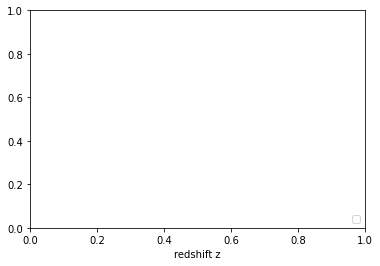

In [10]:
#Display plot - universal aspects of every plot
plt.xlabel("redshift z");
plt.legend(loc='lower right');

Proper Motion Distance vs Redshift
$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
DMDH
[0.         0.04866909 0.09394976 0.13621777 0.17579302 0.21294981
 0.24792482 0.28092354 0.31212534 0.3416876  0.36974906 0.39643255
 0.42184727 0.44609069 0.4692501  0.49140394 0.51262295 0.53297106
 0.55250627 0.5712813  0.58934421 0.60673891 0.6235056  0.63968118
 0.6552996  0.67039211 0.68498759 0.69911273 0.71279226 0.72604913
 0.73890466 0.75137871 0.76348978 0.77525513 0.78669091 0.79781221
 0.80863321 0.81916716 0.82942654 0.83942309 0.84916782 0.85867113
 0.86794285 0.87699221 0.88582797 0.8944584  0.90289134 0.91113419
 0.91919401 0.92707745 0.93479087 0.94234029 0.94973143 0.95696976
 0.96406046 0.97100849 0.97781857 0.9844952  0.99104269 0.99746514
 1.00376649 1.0099505  1.01602075 1.02198071 1.02783366 1.03358277
 1.03923108 1.04478149 1.05023681 1.05559972 1.06087279 1.06605852
 1.07115927 1.07617736 1.08111498 1.08597427 1.09075727 1.09546597
 1.10010226 1.10466798 1.10916

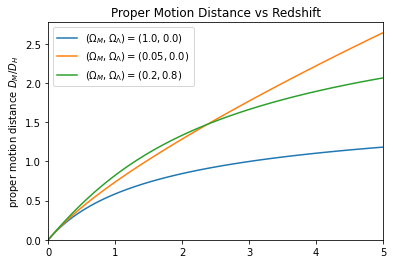

In [10]:
# 1. proper motion distance
print("Proper Motion Distance vs Redshift");
plt.title("Proper Motion Distance vs Redshift");
plt.ylabel(r"proper motion distance $D_M/D_H$");

# Note: I want to create a new version of DMDH with each loop iteration
for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
    print("DMDH")
    print(DMDH)
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, DMDH, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()

Angular Diameter Distance vs Redshift
$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
DADH
[0.         0.04632923 0.08533051 0.11829438 0.14624798 0.17001638
 0.19026788 0.20754799 0.2223051  0.23491023 0.2456722  0.2548495
 0.26265962 0.26928645 0.27488615 0.2795919  0.28351772 0.2867616
 0.28940805 0.29153015 0.29319134 0.29444682 0.29534476 0.29592728
 0.29623132 0.29628937 0.29613001 0.29577846 0.29525704 0.29458551
 0.29378137 0.29286021 0.29183586 0.29072067 0.28952565 0.28826062
 0.28693436 0.28555475 0.28412882 0.28266288 0.28116259 0.27963303
 0.27807878 0.27650391 0.27491213 0.27330673 0.27169071 0.27006672
 0.26843719 0.26680427 0.2651699  0.26353584 0.26190365 0.26027474
 0.25865037 0.25703166 0.25541963 0.25381517 0.25221909 0.2506321
 0.24905484 0.24748787 0.24593167 0.24438669 0.2428533  0.24133183
 0.23982256 0.23832573 0.23684156 0.23537021 0.23391182 0.2324665
 0.23103435 0.22961543 0.22820977 0.22681741 0.22543835 0.22407258
 0.22272009 0.22138083 0.220054

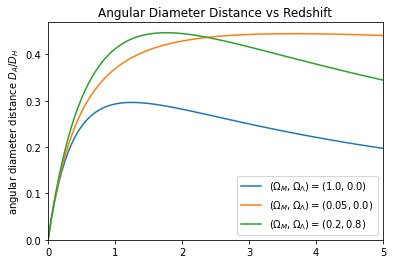

In [11]:
# 2. angular diameter distance
print("Angular Diameter Distance vs Redshift");
plt.title("Angular Diameter Distance vs Redshift");
plt.ylabel(r"angular diameter distance $D_A/D_H$");

# Note: I want to create a new version of DADH with each loop iteration
for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
    DADH = dist_angdiam(z, DMDH, DADH, omega_m, omega_l)
    print("DADH")
    print(DADH)
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, DADH, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()

Luminosity Distance vs Redshift
$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
DLDH
[0.         0.05112713 0.10343963 0.15685682 0.21130677 0.26672501
 0.32305355 0.38023994 0.43823659 0.49700015 0.55649101 0.61667285
 0.67751228 0.73897852 0.80104309 0.86367965 0.92686371 0.99057247
 1.0547847  1.11948053 1.1846414  1.25024987 1.31628959 1.38274518
 1.44960214 1.51684679 1.58446624 1.65244827 1.72078131 1.78945442
 1.85845719 1.92777973 1.99741265 2.06734701 2.13757428 2.20808633
 2.2788754  2.34993407 2.42125527 2.49283219 2.56465835 2.63672752
 2.70903373 2.78157125 2.85433457 2.92731841 3.00051768 3.07392748
 3.14754312 3.22136004 3.29537388 3.36958042 3.44397559 3.51855547
 3.59331626 3.66825429 3.74336603 3.81864805 3.89409702 3.96970976
 4.04548313 4.12141415 4.19749988 4.2737375  4.35012427 4.42665752
 4.50333467 4.58015321 4.65711071 4.7342048  4.81143317 4.8887936
 4.9662839  5.04390196 5.12164571 5.19951316 5.27750236 5.35561139
 5.43383841 5.51218162 5.59063925 

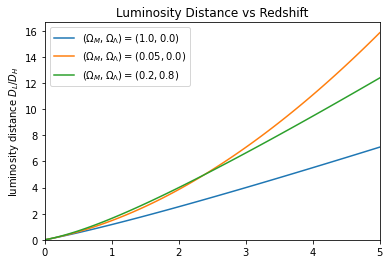

In [12]:
# 3. luminosity distance
print("Luminosity Distance vs Redshift");
plt.title("Luminosity Distance vs Redshift");
plt.ylabel(r"luminosity distance $D_L/D_H$");

for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
    DLDH = dist_lum(z, DMDH, DLDH, omega_m, omega_l)
    print("DLDH")
    print(DLDH)
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, DLDH, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()

Distance Modulus vs Redshift
$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
i = 0
distance molulus DM + 5 log h
length of mu: 100
[       -inf 36.70185251 38.23203037 39.13611258 39.78316253 40.28891423
 40.70496811 41.05888418 41.36713869 41.64037812 41.88588628 42.10886966
 42.31318138 42.50175457 42.67687491 42.84035896 42.9936749  43.13802679
 43.27441462 43.40367824 43.52653004 43.6435796  43.75535275 43.86230628
 43.96483961 44.0633041  44.15801046 44.24923487 44.33722392 44.42219872
 44.50435831 44.58388256 44.66093449 44.73566241 44.80820159 44.87867575
 44.94719841 45.0138739  45.0787984  45.14206073 45.20374311 45.26392177
 45.32266758 45.38004646 45.4361199  45.49094533 45.54457646 45.5970636
 45.64845395 45.69879185 45.74811899 45.79647464 45.84389584 45.89041752
 45.93607272 45.98089268 46.02490699 46.06814367 46.11062935 46.15238928
 46.19344748 46.2338268  46.27354897 46.31263473 46.35110383 46.38897512
 46.42626663 46.46299554 46.49917832 46.53483072 46.5699

<ipython-input-4-a499bbc14b13>:24: RuntimeWarning: divide by zero encountered in log10
  mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
<ipython-input-4-a499bbc14b13>:24: RuntimeWarning: divide by zero encountered in log10
  mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
<ipython-input-4-a499bbc14b13>:24: RuntimeWarning: divide by zero encountered in log10
  mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )


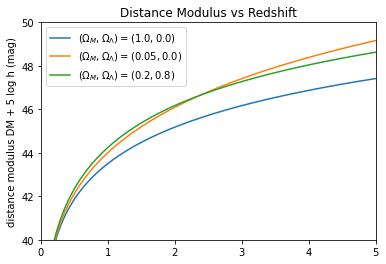

In [13]:
# 4. distance modulus
print("Distance Modulus vs Redshift");
plt.title("Distance Modulus vs Redshift");
plt.ylabel("distance modulus DM + 5 log h (mag)");
ymin = 40
ymax = 50

for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
        
    mu = dist_mod(z, D_H, omega_m, omega_l, DMDH)
    print("i = " + str(i))
    print("distance molulus DM + 5 log h")
    print("length of mu: " + str(len(mu)))
    print(mu)
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, mu, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()

Comoving Volume Element vs Redshift
$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
DVC
$\Omega_k =$ 0.95
$\Omega_\Mu =$ 0.05
$\Omega_\Lambda =$ 0.0
DVC
0.0
DVC


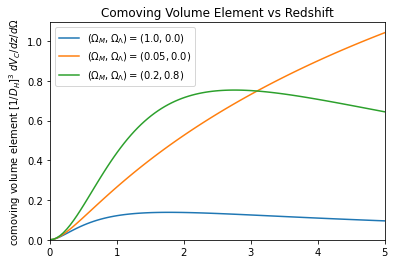

In [11]:
# 5. comoving volume element
print("Comoving Volume Element vs Redshift");
plt.title("Comoving Volume Element vs Redshift");
plt.ylabel(r"comoving volume element $[1/D_H]^3$" + r" $dV_C/dz/d\Omega$");

# generates the same plot regardless of the parameter you give it
for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
    DVC = com_vol(z, DMDH, DVC, omega_m, omega_l, D_H)
    DVC = DVC / D_H**3
    print("DVC")
    print(DVC)
    
    # plot
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, DVC, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()

Lookback Time and Age vs Redshift
tLtH
[0.         0.04749436 0.08960558 0.12715076 0.16079414 0.19108073
 0.21846139 0.24331202 0.26594822 0.28663674 0.30560438 0.32304507
 0.33912553 0.35398979 0.36776284 0.38055362 0.39245749 0.40355822
 0.41392967 0.4236372  0.43273882 0.4412862  0.44932545 0.45689788
 0.46404058 0.47078693 0.47716706 0.48320821 0.48893505 0.49437003
 0.49953355 0.50444422 0.50911903 0.51357356 0.51782206 0.52187763
 0.52575231 0.52945722 0.53300257 0.53639783 0.53965174 0.54277241
 0.54576736 0.54864355 0.55140749 0.55406521 0.55662233 0.55908412
 0.56145546 0.56374096 0.56594489 0.56807127 0.57012387 0.57210623
 0.57402167 0.5758733  0.57766406 0.57939672 0.58107389 0.58269801
 0.58427141 0.58579629 0.5872747  0.58870861 0.59009987 0.59145023
 0.59276136 0.59403484 0.59527217 0.59647475 0.59764395 0.59878105
 0.59988727 0.60096376 0.60201164 0.60303196 0.60402573 0.60499389
 0.60593737 0.60685704 0.60775372 0.60862823 0.60948131 0.61031369
 0.61112608 0.61191913 

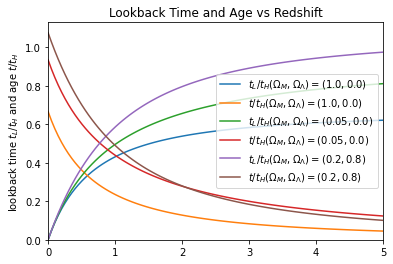

In [12]:
# 6. Lookback time and age vs redshift
print("Lookback Time and Age vs Redshift");
plt.title("Lookback Time and Age vs Redshift");
plt.ylabel(r"lookback time $t_L/t_H$" + r" and age $t/t_H$");

# lookback time and age vs redshift
for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]


    # lookback time
    tLtH = lookback_time(z, tLtH, omega_m, omega_l, H)
    print("tLtH")
    print(tLtH)
    param_text = r"$t_L/t_H \left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, tLtH, label=param_text)

    # age
    age = get_age(z, tLtH, age, omega_m, omega_l, H)
    print("age")
    print(age)
    param_text = r"$t/t_H \left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, age, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()

Dimensionless Intersection Probability vs Redshift
1.0 0.0
dPdz
[1.         1.02494149 1.04929028 1.07308674 1.09636682 1.11916275
 1.14150353 1.16341538 1.18492211 1.20604538 1.226805   1.24721913
 1.26730446 1.2870764  1.30654916 1.32573593 1.34464895 1.36329962
 1.38169856 1.39985569 1.41778031 1.43548113 1.45296631 1.47024357
 1.48732014 1.50420287 1.52089819 1.53741223 1.55375076 1.56991925
 1.58592292 1.6017667  1.61745529 1.63299316 1.64838458 1.6636336
 1.67874412 1.69371983 1.70856429 1.72328087 1.73787284 1.75234331
 1.76669525 1.78093155 1.79505494 1.80906807 1.82297348 1.83677363
 1.85047087 1.86406745 1.87756558 1.89096737 1.90427483 1.91748994
 1.9306146  1.94365063 1.95659981 1.96946386 1.98224442 1.9949431
 2.00756146 2.02010101 2.03256319 2.04494943 2.0572611  2.06949952
 2.081666   2.09376178 2.10578808 2.11774609 2.12963695 2.14146179
 2.15322169 2.16491771 2.17655088 2.18812221 2.19963266 2.21108319
 2.22247473 2.23380818 2.24508442 2.2563043  2.26746866 2.27857833


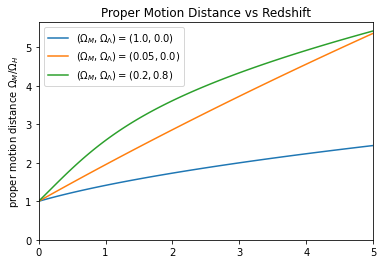

In [13]:
# 7. intersection probability vs redshift
print("Dimensionless Intersection Probability vs Redshift");
plt.title("Proper Motion Distance vs Redshift");
plt.ylabel(r"proper motion distance $\Omega_M/\Omega_H$");

for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    print(omega_m, omega_l)

    dPdz = intersect_prob(z, dPdz, omega_m, omega_l)
    print("dPdz")
    print(dPdz)
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, dPdz, label=param_text)

plt.axis([zmin, zmax, ymin, ymax]);
plt.legend()
plt.show()